In [167]:
import numpy as np
import pandas as pd
import math as math

data = pd.read_csv('data.csv')

Price vs rooms


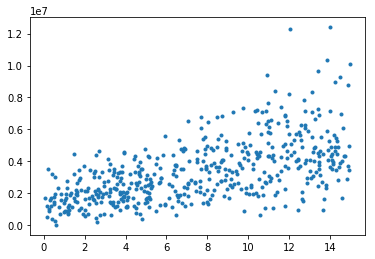

Acreage vs rooms


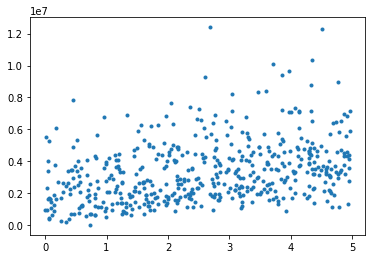

In [18]:
%matplotlib inline 
# annotation to Jupyter to show matplotlib plots inline
import matplotlib.pyplot as plt

print('Price vs rooms')
plt.figure() # creates a new figure to draw in
plt.plot(data['num_rooms'], data['price'], '.') # creates a plot
plt.show()

print('Acreage vs rooms')
plt.figure() # creates a new figure to draw in
plt.plot(data['acreage'], data['price'], '.') # creates a plot
plt.show()

In [3]:
# B^ = cov(y, x) / var(x) (all mean corrected)
# np.dot <= dot product
# np.mean <= calculate mean
# covariance: sum(y - y_ * x - x_)

# y = price, x = rooms

y_bar = np.mean(data['price'])
x_bar = np.mean(data['num_rooms'])
 
covar = np.dot(data['price'] - y_bar, data['num_rooms'] - x_bar)
var = np.dot(data['num_rooms'] - x_bar, data['num_rooms'] - x_bar)

B = covar / var
print(B)
print(covar, var)
print(len(data['price']))


264142.325133
2459805994.1 9312.42652179
500


In [4]:
alpha = y_bar - B * x_bar
print(alpha)

1361481.17193


Price vs rooms


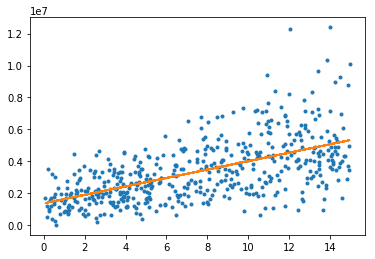

In [5]:
print('Price vs rooms')
plt.figure() # creates a new figure to draw in
plt.plot(data['num_rooms'], data['price'], '.') # creates a plot
estimated_price = (B * data['num_rooms'] + alpha)
plt.plot(data['num_rooms'], estimated_price, '-')
plt.show()

In [545]:

# normalize the data
# choose a learning rate
# fn to calculate predictions given x^i, B^j
# write a fn to calculate a derivative (gradient) at any point x
# loop to iteratively recalculate B^j+1
# put x into the range between -1 and 1
# can take (x - min(x) / max(x) - min(x))
data = pd.read_csv('data2.csv')

if isinstance(data, pd.DataFrame):
    data = data.as_matrix()

def normalize(data):
    nm = np.zeros(data.shape)
    for i in range(data.shape[1] - 1):
        nm[:,i] = normalize_col(data[:, i])
    nm[:, -1] = 1
    return (nm, normalize_col(data[:, -1]))

def normalize_col(col):
    x_min = np.min(col)
    x_max = np.max(col)
    return 2 * (((col - x_min) / (x_max - x_min)) - 0.5)

def unnormalize_col(new_col, old_col):
    x_min = np.min(old_col)
    x_max = np.max(old_col)
    return ((new_col / 2) + 0.5) * (x_max - x_min) + x_min

def split_data(X, y, split=0.8):
    random_range = np.arange(X.shape[0])
    np.random.shuffle(random_range)
    shuffled_X = X[random_range, :]
    shuffled_y = y[random_range]
    
    split_point = int(data.shape[0] * split)
    return (
        (shuffled_X[0:split_point, :], shuffled_X[split_point:, :]),
        (shuffled_y[0:split_point], shuffled_y[split_point:])
    )
        
X, y = normalize(data)


(training_x, validation_x), (training_y, validation_y)  = split_data(X, y)


# print('Price vs rooms')
# plt.figure() # creates a new figure to draw in
# # plt.plot(X[:, 1], y, '.') # creates a plot
# estimated_price = (B * training_x[:, 1] + alpha * training_x[:, -1])
# # plt.plot(X[:, 1], estimated_price, '-')
# plt.plot(X[:, 1], y, '.')
# plt.show()

In [546]:
lr = 0.1

In [547]:
def grad(X, y, coefficients, f_idx, batch_size):
    # sum over all observations, 2 * true price - predicted price (given coefficients) * - value of feature at observation
    sum = 0
    for _ in range(batch_size):
        i = np.random.randint(X.shape[0])
        error = np.dot(X[i,:], coefficients)
        sum += 2 * (y[i] - error) * -(X[i, f_idx])
    return sum / batch_size

In [548]:
# def recalc_coefficients(X, y, lr, coefficients, batch_size):
#     new_coefficients = np.zeros_like(coefficients)
#     for i in range(coefficients.shape[0]):
#         d = grad(X, y, coefficients, i, batch_size)
#         new_coefficients[i] = coefficients[i] - d * lr * batch_size / X.shape[0]
#     return new_coefficients

def recalc_coefficients(X, y, lr, coefficients, batch_size, lam):
    original_examples_count = X.shape[0]
    batch_idxs = np.random.randint(size=batch_size, low=0, high=original_examples_count)
    X = X[batch_idxs, :]
    y = y[batch_idxs]
    errors = y - np.dot(X, coefficients)
    gradient_of_errors = np.sum(2 * (X.T * -errors).T, axis=0) / batch_size 
    gradient_of_penalty = 2 * coefficients * lam
    gradient_of_loss = gradient_of_errors + gradient_of_penalty
    return coefficients - gradient_of_loss * lr * batch_size / original_examples_count

In [554]:
def train(X, y, validation_x, validation_y, lr, batch_size=128, iters=1000, lam=1.0):
    coefficients = np.zeros(X.shape[1])
    train_errors = []
    validation_errors = []
    for _ in range(iters):
        if _ % 100 == 0:
            print(_)
        coefficients = recalc_coefficients(X, y, lr, coefficients, batch_size, lam)
        train_errors.append(calc_average_error(X, y, coefficients))
        validation_errors.append(calc_average_error(validation_x, validation_y, coefficients))
    return coefficients, train_errors, validation_errors

def calc_average_error(X, y, coefficients):
    errors = np.dot(X, coefficients) - y
    return np.sum(errors ** 2) / X.shape[0]

model, training_errors, validation_errors = train(
    training_x, 
    training_y, 
    validation_x, 
    validation_y, 
    0.1, 
    batch_size=training_x.shape[0], 
    iters=100,
    lam=0.1
)
print(model)

0
[ 0.00160079 -0.00621415  0.0040267  ..., -0.00740195  0.00074541
  0.01488913]


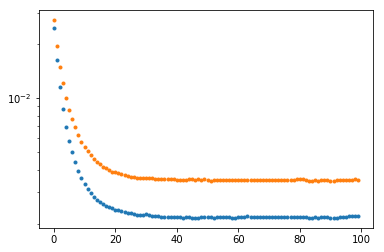

In [555]:
plt.figure()
plt.yscale('log')
plt.plot(range(len(training_errors)), training_errors, '.')
plt.plot(range(len(training_errors)), validation_errors, '.')
plt.show()

In [556]:
def predict_price(model, X, original_y):
    raw_predictions = np.dot(X, model)
    return unnormalize_col(raw_predictions, original_y)

training_predictions = predict_price(model, training_x, data[:, -1])

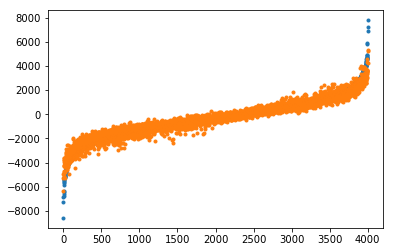

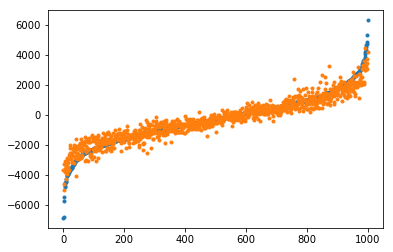

In [557]:
plt.figure()

original_y = unnormalize_col(training_y, data[:, -1])
order = np.argsort(original_y)

plt.plot(range(training_predictions.shape[0]), original_y[order], '.')
plt.plot(range(training_predictions.shape[0]), training_predictions[order], '.')
plt.show()

plt.figure()

unnormalized_validation = unnormalize_col(validation_y, data[:, -1])
validation_predictions = predict_price(model, validation_x, data[:, -1])
order = np.argsort(unnormalized_validation)

plt.plot(range(validation_y.shape[0]), unnormalized_validation[order], '.')
plt.plot(range(validation_y.shape[0]), validation_predictions[order], '.')

In [558]:
# correlation = 1 - var(price - est)/var(price)
variance_of_error = np.sum((validation_predictions - unnormalized_validation) ** 2) / validation_predictions.shape[0]
variance_of_price = np.sum((unnormalized_validation - np.mean(unnormalized_validation)) ** 2) / validation_predictions.shape[0]
r_squared = 1 - variance_of_error / variance_of_price
print(f"R squared for validation: {r_squared}")

training_variance_of_error = np.sum((training_predictions - original_y) ** 2) / predictions.shape[0]
training_variance_of_price = np.sum((original_y - np.mean(original_y)) ** 2) / predictions.shape[0]
training_r_squared = 1 - training_variance_of_error / training_variance_of_price
print(f"R squared for training: {training_r_squared}")



R squared for validation: 0.9132588470998935
R squared for training: 0.9466352345998161


In [539]:
print(predictions[0:5])
print(original_y[0:5])

[  -15.15909234  -263.51586697  -155.84463504 -1696.3219631   1268.20463853]
[ 195.8236662    -8.05813371  -10.99697538 -139.48308362 -940.90924556]
